In [1]:
import pandas as pd
from scipy.stats import ttest_rel
import numpy as np
import random
#from pandasql import sqldf
#pysqldf = lambda q: sqldf(q, globals())
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats


##rate dt stats:
def rate_dt_stats(df,_assign_dict,fea,elem):
    fea_dict={}
    for i in _assign_dict:
        dftmp=df[df['type'].isin(_assign_dict[i])][['dt',fea,'user_id']]
        ttmp=dftmp.groupby(['dt']).nunique().user_id
        etmp=dftmp[dftmp[fea]==elem].groupby(['dt']).nunique().user_id
        fea_dict[i]=etmp/ttmp
    return fea_dict

##rate stats:
def rate_stats(df,_assign_dict,fea,elem):
    fea_dict={}
    for i in _assign_dict:
        dftmp=df[df['type'].isin(_assign_dict[i])][[fea,'user_id']]
        ttmp=dftmp['user_id'].nunique()
        etmp=dftmp[dftmp[fea]==elem]['user_id'].nunique()
        fea_dict[i]=[ttmp,etmp]
    return fea_dict

##num stats:
def num_stats(df,_assign_dict,fea):
    fea_dict={}
    for i in _assign_dict:
        dftmp=df[df['type'].isin(_assign_dict[i])][['dt',fea]]
        if fea=='user_id':
            fea_dict[i]=dftmp.groupby(['dt']).nunique().user_id/len(_assign_dict[i])
        if fea!='user_id':
            dftmpuser=df[df['type'].isin(_assign_dict[i])][['dt','user_id']]
            fea_dict[i]=dftmp.groupby(['dt']).agg(['sum'])[fea]['sum']/dftmpuser.groupby(['dt']).nunique().user_id
    return fea_dict

##per dau
def per_stats(df,_assign_dict,fea):
    fea_dict={}
    for i in _assign_dict:
        fea_dict[i]=df[df['type'].isin(_assign_dict[i])][['user_id',fea]].groupby(['user_id']).agg(['sum'])[fea]['sum']
    return fea_dict


#rate test
def rate_test(r_dict):
    p_list=[]
    for i in r_dict:
        if i==len(r_dict)-1:
            break
        else:
            for j in range(i+1,len(r_dict)):
                stat, pval = proportions_ztest([r_dict[i][1],r_dict[j][1]], [r_dict[i][0],r_dict[j][0]])
                p_list.append(pval)
    return p_list

#num test
def num_test(n_dict):
    p_list=[]
    for i in n_dict:
        if i==len(n_dict)-1:
            break
        else:
            for j in range(i+1,len(n_dict)):
                stat, pval = stats.ttest_rel(n_dict[i],n_dict[j])
                p_list.append(pval)
    return p_list

#per test
def per_test(p_dict):
    p_list=[]
    for i in p_dict:
        if i==len(p_dict)-1:
            break
        else:
            for j in range(i+1,len(p_dict)):
                stat, pval = stats.ttest_ind(p_dict[i],p_dict[j])
                p_list.append(pval)
    return p_list

#FDR 
def FDR(p_values):
    p_values.sort()
    s=range(1,len(p_values)+1)
    q_values=[]
    p_re=p_values[::-1]
    for i in range(len(p_values)):
        if i==0:
            q_values.append(p_re[0])
        else:
            q_values.append(min(q_values[i-1],p_re[i]*len(p_values)/(len(p_values)-i)))
    q_values.reverse()
    return(q_values)

##aatest
def _aa_group(df, _list, nsteps, features, m_sign, min_p, fdr=True): 
    if sum(_list) > len(df.type.unique()):
        print('exceed the limitation of number of slots')
    else:
        succ_dict={}
        fail_dict={}
        for i in range(nsteps):
            assignments={}
            _slot_list=list(df.type.unique())
            random.seed(i)
            random.shuffle(_slot_list)
            for j in range(len(_list)):
                if j==0:
                    assignments[j]=_slot_list[0:_list[j]]
                else:
                    assignments[j]=_slot_list[sum(_list[0:j]):sum(_list[0:j])+_list[j]]
            
            p_dict={}   #dict p-values
            if 'rate' in features:
                if len(features['rate']) > 0:
                    for l in features['rate']:
                        p_dict[l]=rate_test(rate_stats(df,assignments,l[0],l[1]))
                
            if 'num' in features:
                if len(features['num']) > 0:
                    for k in features['num']:
                        p_dict[k]=num_test(num_stats(df,assignments,k))
                
            if 'per' in features:
                if len(features['per']) > 0:
                    for t in features['per']:
                        p_dict[t]=per_test(per_stats(df,assignments,t))
            
            if fdr==True:
                for keys in p_dict:
                    p_dict[keys]=FDR(p_dict[keys])
                
            n_sign=sum(np.sum(pd.DataFrame(p_dict)<0.05))
            n_min=sum(np.sum(pd.DataFrame(p_dict)<min_p))
            
            if (n_sign<=m_sign) & (n_min==0):
                succ_dict[i]=assignments
            else:
                fail_dict[i]=assignments
        return succ_dict,fail_dict
                    

In [22]:
df_all=pd.read_csv('aatestana.csv')

In [3]:
df_all.head()

,dt,user_id,type,gender,os,revenue,swipe,likes,match,messages
0,2019-08-01,1735,131,male,ios,0.0,130,130,0,0
1,2019-08-01,2335,313,male,ios,0.0,99,37,1,0
2,2019-08-01,3835,775,male,ios,0.0,0,0,0,0
3,2019-08-01,5615,679,male,android,0.0,133,49,19,11
4,2019-08-01,6135,418,male,android,0.0,132,132,0,0


In [4]:
len(df_all)

101009120

In [5]:
#before exp
aadf=df_all[df_all.dt<'2019-08-08']

In [10]:
sdict,fdict=_aa_group(aadf,[50,50],200,{'rate':[('gender','female'),('os','ios')],'num':['user_id','revenue'],'per':['swipe','messages','match','likes']},0,0.05)

In [19]:
len(sdict)
print(type(sdict))
str1=str(sdict)
with open('strout_sdict.txt','w') as f:
    f.write(str1)

<class 'dict'>


In [20]:
len(fdict)
print(type(fdict))
str2=str(fdict)
with open('strout_fdict.txt','w') as f:
    f.write(str2)

<class 'dict'>


In [23]:
#after exp
abdf=df_all[df_all.dt>'2019-08-07']

In [21]:
def _abtest(df, assignments, features, fdr=True):
    p_dict={}   #dict p-values
    if 'rate' in features:
        if len(features['rate']) > 0:
            for l in features['rate']:
                p_dict[l]=rate_test(rate_stats(df,assignments,l[0],l[1]))

    if 'num' in features:
        if len(features['num']) > 0:
            for k in features['num']:
                p_dict[k]=num_test(num_stats(df,assignments,k))

    if 'per' in features:
        if len(features['per']) > 0:
            for t in features['per']:
                p_dict[t]=per_test(per_stats(df,assignments,t))
    if fdr==True:
        for keys in p_dict:
            p_dict[keys]=FDR(p_dict[keys])
                
    n_sign=sum(np.sum(pd.DataFrame(p_dict)<0.05))
    
    return n_sign
    

In [26]:
sdict.keys()

dict_keys([1, 9, 11, 16, 18, 27, 29, 32, 33, 37, 42, 45, 47, 50, 54, 55, 56, 57, 64, 68, 71, 72, 75, 77, 80, 81, 84, 86, 87, 88, 89, 92, 96, 101, 102, 104, 105, 107, 113, 116, 117, 119, 121, 123, 128, 130, 134, 139, 140, 142, 147, 149, 152, 154, 160, 164, 165, 167, 168, 170, 174, 176, 178, 182, 184, 188, 193, 194, 199])

In [30]:
def _abresult(df,ddict,features):
    _result=[]
    for a in ddict:
        _result.append(_abtest(df,ddict[a],features))
    return _result

In [31]:
slist=_abresult(abdf,sdict,{'rate':[('gender','female'),('os','ios')],'num':['user_id','revenue'],'per':['swipe','messages','match','likes']})

In [32]:
flist=_abresult(abdf,fdict,{'rate':[('gender','female'),('os','ios')],'num':['user_id','revenue'],'per':['swipe','messages','match','likes']})

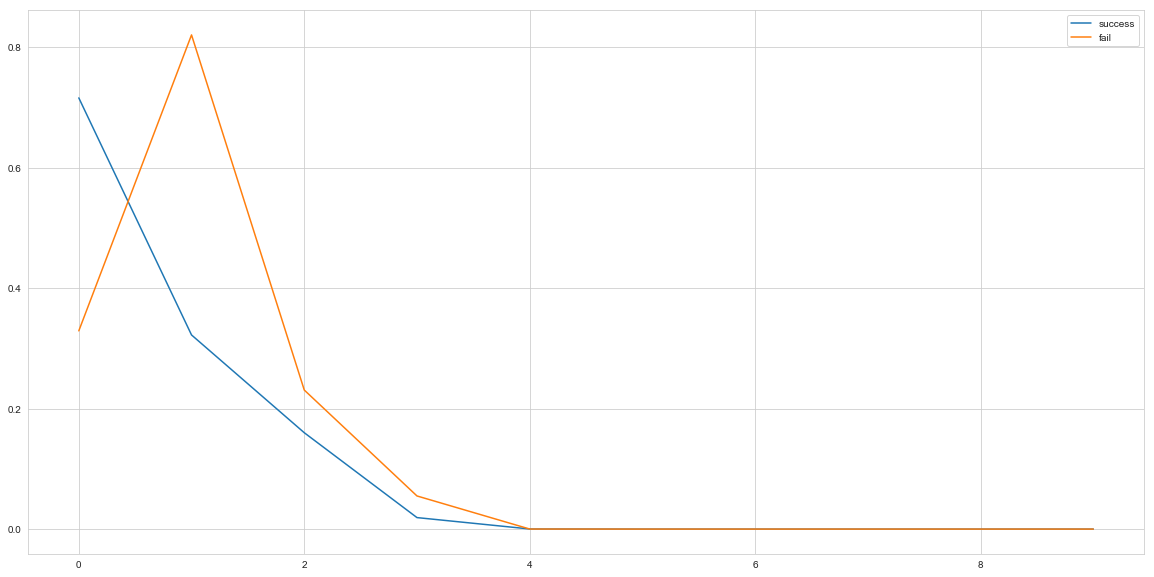

<Figure size 432x288 with 0 Axes>

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
fig=plt.figure(figsize=(20,10))
sns.set_style('whitegrid')
x = np.arange(0, 10, 1)
density_suc = stats.kde.gaussian_kde(slist)
density_fail= stats.kde.gaussian_kde(flist)
plt.plot(x, density_suc(x))
plt.plot(x, density_fail(x))
plt.legend(labels=['success','fail'])
plt.show()
plt.savefig('density plot of number of significant hypo')

In [54]:
print(flist)

[1, 0, 1, 1, 1, 1, 2, 1, 1, 3, 2, 0, 0, 2, 0, 1, 1, 0, 1, 3, 1, 1, 2, 0, 1, 1, 0, 1, 1, 2, 1, 1, 3, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 2, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 2, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 0, 2, 0, 2, 2, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 0, 0, 2, 1, 1, 1, 2]
